## Зачистка данных.

Проблемы:
- ✅️ Пропущенные значения ("M") — встречаются в числовых колонках, нужно заменить на среднее по неделе.

- ✅️ Чёрточки ("-") — в sunrise и sunset, означают отсутствие данных, тоже заменяются на среднее по неделе.

- ✅️ Трейс-значения ("T") — в snowfall и preciptotal, обозначают слишком малые значения, заменяем на 0.001.

- ✅️ Смешанные типы данных — строки в числовых колонках, требует явного приведения типов.

- ✅️ Неструктурированный codesum — содержит погодные явления в виде строк (например, "RA FG"), нужно парсить в бинарные признаки.

- ✅️ Дату преобразовать в набор числовых фич: день недели, номер недели, месяц в году, год, (day_of_week, week_of_year, month, year, is_weekend)

- ✅️ Надо присоединить отметки о праздничных днях в США, так как они будут сильно влиять на units.

- ✅️ Добавить фичу rain_streak, сколько дней подряд до этого идёт дождь. Есть предположение, что фича ценная, так как на людей вляет смена погоды после долгого накопления.

- ✅️ dry_streak - аналогично, сколько уже дней без дождя. Накопительный эффект, и смена погоды после этого накопления должны дать большую ценность.

- ✅️ (avg_temp_next_day, rain_next_day) - прогноз погоды на завтра. Как вариант можно добавить шуму. Не data leak.
Модель не станет магически угадывать будущее — она всё равно видит только «завтра будет +18 °C и дождь», а не продажи из будущего.
Фактическое vs. прогнозное значение отличаются слабо → влияние на качество будет в пределах погрешности данных о продажах.

### Загружаем данные

In [1]:
import pandas as pd
import numpy as np

weather_df = pd.read_csv('./data/weather.csv')

display(weather_df.head())
display(weather_df.info())

,station_nbr,date,tmax,tmin,tavg,snowfall,preciptotal,sunrise,sunset,depart,dewpoint,wetbulb,heat,cool,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum
0,1,2012-01-01,52.000000,31.000000,42.0,0,0,725.716518,1701.265625,6.653439,36.0,40.0,23.0,0.0,29.78,29.92,3.6,20.0,4.6,-
1,1,2012-01-02,51.000000,31.000000,41.5,0,0,725.716518,1701.265625,6.653439,26.0,35.0,24.0,0.0,29.44,29.62,9.8,24.0,10.3,-
2,1,2012-01-03,44.666667,24.333333,35.0,0,0,725.716518,1701.265625,6.653439,4.0,18.0,43.0,0.0,29.67,29.87,10.8,31.0,11.6,-
3,1,2012-01-04,40.500000,20.500000,31.0,0,0,725.716518,1701.265625,6.653439,-1.0,14.0,46.0,0.0,29.86,30.03,6.3,27.0,8.3,-
4,1,2012-01-05,40.000000,21.400000,31.2,0,0,725.716518,1701.265625,6.653439,13.0,25.0,33.0,0.0,29.67,29.84,6.9,25.0,7.8,-


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   station_nbr  20517 non-null  int64  
 1   date         20517 non-null  object 
 2   tmax         20517 non-null  float64
 3   tmin         20517 non-null  float64
 4   tavg         20517 non-null  float64
 5   snowfall     20517 non-null  int64  
 6   preciptotal  20517 non-null  int64  
 7   sunrise      20517 non-null  float64
 8   sunset       20517 non-null  float64
 9   depart       20517 non-null  float64
 10  dewpoint     20517 non-null  float64
 11  wetbulb      20517 non-null  float64
 12  heat         20517 non-null  float64
 13  cool         20517 non-null  float64
 14  stnpressure  20517 non-null  float64
 15  sealevel     20517 non-null  float64
 16  resultspeed  20517 non-null  float64
 17  resultdir    20517 non-null  float64
 18  avgspeed     20517 non-null  float64
 19  code

None

### Общая очистка
Ячейки, содержащие 'M' и '-' обнуляем, ячейки содержащие 'T', заполняем очень малым числом.\
Все колонки приводим к нормальным типам int, float, datetime

In [5]:
# 1. Преобразование колонки date в datetime
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.sort_values('date').reset_index(drop=True)

# Список колонок с "M" и "-"
cols_with_empty = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
               'heat', 'cool', 'snowfall', 'preciptotal', 'stnpressure',
               'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
               'sunrise', 'sunset']

In [26]:
# Заменяем "M" и "-" на NaN
weather_df[cols_with_empty] = weather_df[cols_with_empty].replace({'M': np.nan, '-': np.nan})

# Преобразуем в float (если есть "T" — для snowfall и preciptotal, заменим на маленькое значение)
weather_df['snowfall'] = weather_df['snowfall'].replace({'T': 0.001})
weather_df['preciptotal'] = weather_df['preciptotal'].replace({'T': 0.001})

In [6]:
# Преобразуем всё в float
for col in cols_with_empty:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')

### Добавим год и номер недели
Постые значения будем заполнять средними недельными.\
Сначала того же года, той же станции, потом по всем годам, потом по всем станциям.

In [8]:
weather_df['year'] = weather_df['date'].dt.year
weather_df['week'] = weather_df['date'].dt.strftime('%U').astype(int)

from walmart_helper import fill_weekly_station_year
from walmart_helper import fill_weekly_station
from walmart_helper import fill_week_global

### Выполняем заполнение
`TODO: по хорошему вместо fill_week_global можно брать значения с ближайших станций.`

In [9]:
for col in cols_with_empty:
    weather_df = fill_weekly_station_year(weather_df, col)
    weather_df = fill_weekly_station(weather_df, col)
    weather_df = fill_week_global(weather_df, col)

Проверяем

In [10]:
display(weather_df[cols_with_empty].isna().sum())
display(weather_df.head())

tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
sunrise        0
sunset         0
dtype: int64

,station_nbr,date,tmax,tmin,tavg,snowfall,preciptotal,sunrise,sunset,depart,...,heat,cool,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum,year,week
0,1,2012-01-01,52.0,31.0,42.0,0,0,725.716518,1701.265625,6.653439,...,23.0,0.0,29.78,29.92,3.6,20.0,4.6,-,2012,1
1,3,2012-01-01,55.0,34.0,45.0,0,0,735.000000,1720.000000,9.000000,...,20.0,0.0,29.77,30.47,9.9,31.0,10.0,-,2012,1
2,20,2012-01-01,59.0,41.0,50.0,0,0,725.716518,1701.265625,6.653439,...,15.0,0.0,29.78,30.48,10.9,33.0,10.8,-,2012,1
3,19,2012-01-01,38.0,25.0,32.0,0,0,723.000000,1628.000000,10.000000,...,33.0,0.0,29.06,29.79,14.6,29.0,15.6,-,2012,1
4,4,2012-01-01,63.0,47.0,55.0,0,0,728.000000,1742.000000,4.000000,...,10.0,0.0,29.79,30.48,8.0,35.0,8.2,-,2012,1


## Парсим коды из `codesum`
Эта колонка содержит в себе бэйджи, обозначающие некое погодное явление:
- `+FC` - TORNADO/WATERSPOUT
- `FC` - FUNNEL CLOUD
- `TS` - THUNDERSTORM
- `GR` - HAIL
- `RA` - RAIN
- `DZ` - DRIZZLE
- `SN` - SNOW
- `SG` - SNOW GRAINS
- `GS` - SMALL HAIL &/OR SNOW PELLETS
- `PL` - ICE PELLETS
- `IC` - ICE CRYSTALS
- `FG+` - HEAVY FOG (FG & LE.25 MILES VISIBILITY)
- `FG` - FOG
- `BR` - MIST
- `UP` - UNKNOWN PRECIPITATION
- `HZ` - HAZE
- `FU` - SMOKE
- `VA` - VOLCANIC ASH
- `DU` - WIDESPREAD DUST
- `DS` - DUSTSTORM
- `PO` - SAND/DUST WHIRLS
- `SA` - SAND
- `SS` - SANDSTORM
- `PY` - SPRAY
- `SQ` - SQUALL
- `DR` - LOW DRIFTING
- `SH` - SHOWER
- `FZ` - FREEZING
- `MI` - SHALLOW
- `PR` - PARTIAL
- `BC` - PATCHES
- `BL` - BLOWING
- `VC` - VICINITY

Допустим давайте превратим каждое из этих явлений в отдельный признак. Спорно на самом деле, но попробую. Причём лучше я сделаю эти признаки не бинарными, а small int, со значениями 0, 1, 2. Например строка с `FG+` будет содержать в ячейке fg значение 2, если просто бэйдж без "+", то 1, нету бэйджа - 0.

In [19]:
import re

weather_df[['FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']]=0
codesum_series = weather_df['codesum'].fillna('')

# 1. Собираем все уникальные значения бэйджей
all_tokens = set()
for line in codesum_series:
    tokens = line.split()
    for t in tokens:
        # отрезаем + если есть (так как FG+ → FG как код)
        base = t.rstrip('+')
        all_tokens.add(base)

# 2. Создаём колонки для каждого кода
for code in sorted(all_tokens):
    col = code.upper()
    
    def extract_value(s):
        if f"{code}+" in s or f"+{code}" in s:
            return 2
        elif code in s.split():
            return 1
        else:
            return 0

    weather_df[col] = codesum_series.apply(extract_value)

In [18]:
display(weather_df[weather_df['FG'] == 2])
display(weather_df[['codesum', 'FG', 'RA', 'SN', 'TS']].sample(5))

,station_nbr,date,tmax,tmin,tavg,snowfall,preciptotal,sunrise,sunset,depart,...,PY,SQ,DR,SH,FZ,MI,PR,BC,BL,VC


,codesum,FG,RA,SN,TS
4168,-,0,0,0,0
10313,-,0,0,0,0
3062,-,0,0,0,0
20172,-,0,0,0,0
1342,-,0,0,0,0


### Матрица корреляций
Просто посмотреть

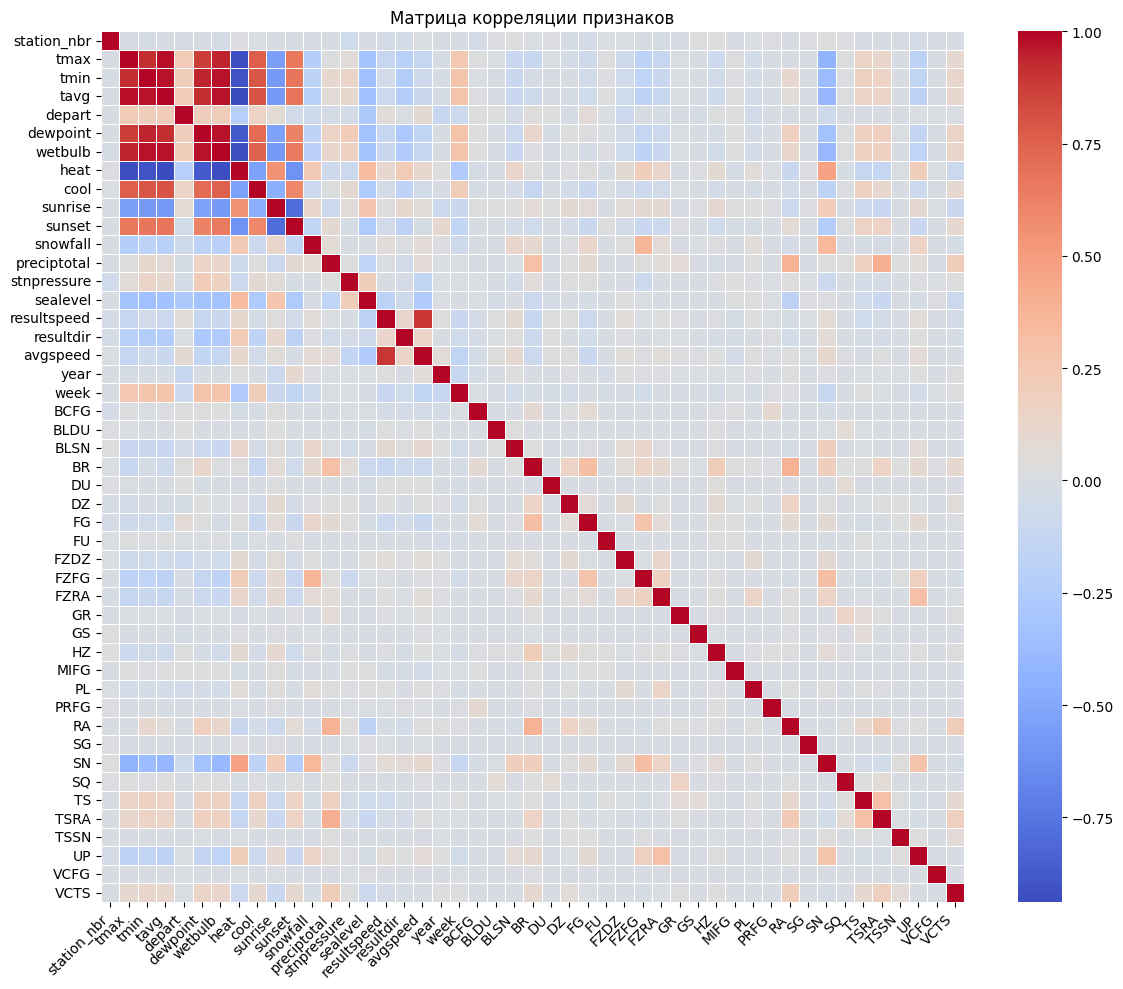

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = weather_df.select_dtypes(include=['number'])

# 1. Вычисление матрицы корреляции
correlation_matrix = numeric_df.corr()

# 2. Настройка размера графика
plt.figure(figsize=(12, 10))  # Уменьшите значения, если нужно еще мельче

# 3. Создание heatmap с настройками
sns.heatmap(correlation_matrix,
            annot=False,       # Отключаем отображение значений (слишком много)
            cmap="coolwarm",   # Цветовая палитра (можно менять)
            linewidths=.5,     # Разделительные линии между ячейками
            fmt=".2f",         # Формат чисел (не используется, т.к. annot=False)
            cbar=True,         # Показывать цветовую шкалу
            xticklabels=True,  # Показывать подписи по оси X
            yticklabels=True)  # Показывать подписи по оси Y


# Поворот подписей оси X для лучшей читаемости (опционально)
plt.xticks(rotation=45, ha="right") #Можно закомментировать, если не влезает.

# Добавление заголовка
plt.title("Матрица корреляции признаков")

# Отображение графика
plt.tight_layout() #Предотвращает обрезание подписей
plt.show()

### Извлекаем из даты числовые признаки

Дату преобразовать в набор числовых фич:

- `day_of_week` - День недели
- `week_of_year` - Номер недели
- `month` - Месяц в году
- `year` - Год
- `is_weekend` - Это выходной
- `is_holiday` - Это праздник

In [15]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday

# --- 1. Базовые календарные признаки ---
weather_df['day_of_week']  = weather_df['date'].dt.dayofweek          # 0=Пн … 6=Вс
# weather_df['week_of_year'] = weather_df['date'].dt.strftime('%U').astype(int)         # ISO‑нумерация
weather_df['month']        = weather_df['date'].dt.month
weather_df['year']         = weather_df['date'].dt.year
weather_df['is_weekend']   = weather_df['date'].dt.dayofweek.isin([5, 6]).astype(int)

# --- 2. Праздники (пример – Россия) -------------------------------
class RUHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year',          month=1, day=1, observance=nearest_workday),
        Holiday('Defender Day',      month=2, day=23, observance=nearest_workday),
        Holiday('Womens Day',        month=3, day=8, observance=nearest_workday),
        Holiday('Labour Day',        month=5, day=1, observance=nearest_workday),
        Holiday('Victory Day',       month=5, day=9, observance=nearest_workday),
        Holiday('Russia Day',        month=6, day=12, observance=nearest_workday),
        Holiday('Unity Day',         month=11, day=4, observance=nearest_workday),
    ]

# создаём сет с датами‑праздниками
holidays = RUHolidayCalendar().holidays(
    start=weather_df['date'].min(), 
    end=weather_df['date'].max()
)

weather_df['is_holiday'] = weather_df['date'].isin(holidays).astype(int)

### Как долго уже идёт или не идёт дождь
- rain_streak: сколько подряд предыдущих дней шёл дождь.
- dry_streak: сколько подряд предыдущих дней было сухо.

In [20]:
# Булевы признаки
weather_df['is_rain'] = (weather_df['RA'] != 0).astype(int)
weather_df['is_dry']  = 1 - weather_df['is_rain']          # 1, если дождя нет

# --- streak дождя ---
weather_df['rain_streak'] = (
    weather_df['is_rain']
      .groupby((weather_df['is_rain'] == 0).cumsum())
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype(int)
)

# --- streak сухой погоды ---
weather_df['dry_streak'] = (
    weather_df['is_dry']
      .groupby((weather_df['is_dry'] == 0).cumsum())
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype(int)
)

# очистим временные флаги
weather_df.drop(columns=['is_rain', 'is_dry'], inplace=True)


### Добавляем в данные прогноз на завтра
Не считаем это Data Leak, в реальности люди действительно знают прогноз погоды на завтра, весьма близкий к реальности.
Кроме того речь ведь о субъективном решении, так что точное знание модели о завтрашней погоде вряд ли даст ей не честной подсказки.

In [21]:
weather_df['avg_temp_next_day'] = weather_df['tavg'].shift(-1).fillna(weather_df['tavg'])
weather_df['rain_next_day']     = weather_df['RA'].shift(-1).fillna(weather_df['RA'])

### Сколько дней до ближайшего праздника

Позволяет модели уловить нарастающий спрос (например, подарки за 3–5 дней до Рождества)

In [22]:
def days_to_next_holiday(date):
    d = np.datetime64(date, 'D')
    # разницы в днях
    deltas = (holidays - d) / np.timedelta64(1, 'D')
    # выбираем минимальную ≥ 0
    positive = deltas[deltas >= 0]
    return int(positive.min()) if positive.size else 365

weather_df['days_to_holiday'] = weather_df['date'].apply(days_to_next_holiday)


### Сохранение

In [23]:
weather_df.to_csv('./data/weather.csv')